In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
#DataBlock 설정이야.
#이렇게 설정한 “템플릿”에 따라 데이터로더를 만들 수 있어.

pets = DataBlock(blocks = (ImageBlock, CategoryBlock), #입출력 데이터 형태를 설정해.
get_items=get_image_files, #이미지 데이터 가져오는 방법 설정해.
splitter=RandomSplitter(seed=42), #검증용 데이터 분리할 방법 설정해.
get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), #레이블 추출하는 방법 설정해.
item_tfms=Resize(460), #아이템단위 조정이야. 모든 이미지의 사이즈를 460으로 통일해서 배치를 만들 수 있도록 해.
batch_tfms=aug_transforms(size=224,min_scale=0.75)) #배치단위 조정이야. 회전하고 비트는 변형을 추가해.

#숫자가 들어간 파일명에서 레이블 추출할거야.
#using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name')
#using_attr은 fastai의 함수로, 어떤 속성에서 값을 추출하는 기능이야. 여기서는 파일명에서 레이블을 추출하기 위해서 사용해.

#'(.+)_\d+.jpg$') 는 파일명을 의미해.
#'(.+)' 모든 문자열
#'_' 밑줄
#'\d+' 하나 이상의 숫자
#'.jpg$' 파일 이름이 .jpg로 끝남 ($는 문자열의 끝을 나타냄)
#예: wheaten_terrier_3.jpg
#처음에 붙인 r은 raw string을 뜻하며, 이스케이프 문자를 무시하고 문자 그대로 해석하도록 하기 위해서야.

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.540947,0.327838,0.105548,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.530887,0.311244,0.097429,00:35
1,0.349648,0.229182,0.075778,00:35


[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('chihuahua', 'miniature_pinscher', 5)]

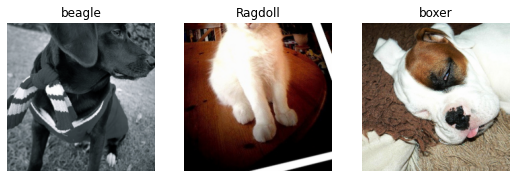

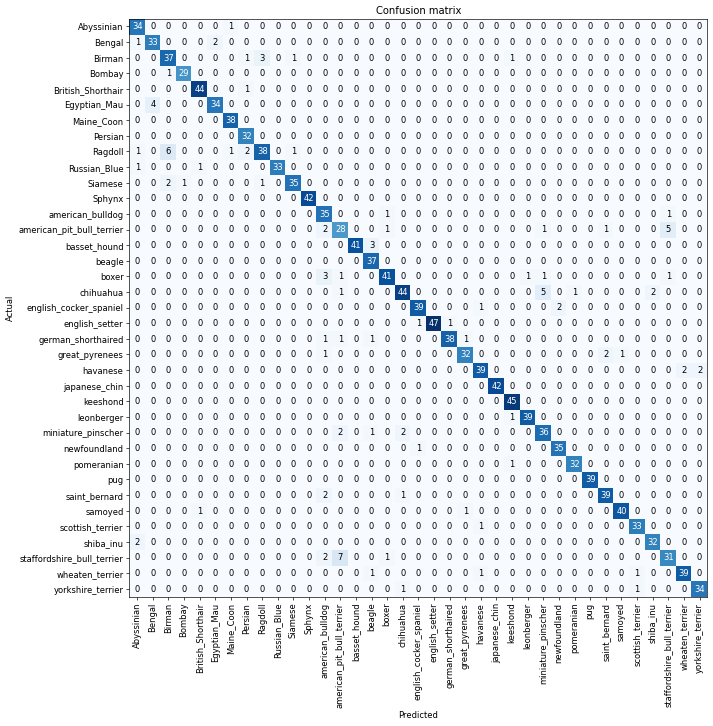

In [5]:
#Dataloaders를 만들어.
#우리가 설정한 템플릿을 가지고, 이미지경로를 최종적으로 넣어서 만들어.
#그러면 DataBlock설정에 따라 이미지-레이블 쌍이 미니배치 형태로 만들어져.
dls = pets.dataloaders(path/"images")


#배치를 확안하여 이상이 있는지를 확인해.
dls.show_batch(nrows=1, ncols=3)


#학습을 진행해.
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune (2)


#모델이 못한 부분을 확인해.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#figsize는 플롯의 크기를 정의해. 여기서는 12X12 크기의 플롯을 생성해.
#dpi는 'dots per inch'로 플롯의 해상도를 지정해. 숫자가 클수록 높은 해상도야.
interp.most_confused(min_val=5) #최소 5번 잘못 예측한 부분만 추출하는 방법이야
#결과는 (모델 예측, 실제 정답, 오류 횟수)의 순서로 나와.
#예: ('Ragdoll', 'Birman', 9)

In [9]:
#차별적 학습률로 학습해볼거야.
learn = cnn_learner(dls, resnet34, metrics=error_rate)

learn.fit_one_cycle(3, 3e-3)  #(1)
learn.unfreeze()  #(2)
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))  #(3)

#resnet34 모델은 이미 이미지분류를 잘하는 모델이야.
#따라서 마지막 활성화함수 계층(최종적으로 동물 37종의 출력으로 내보내는 계층)만 학습시키면 돼.

#(1) 처음에는 초기 레이어를 동결시키고 마지막 계층만 큰 학습률로 학습시켜.
#이런 기능은 fit_one_cycle의 기본 기능이야.
#(2) 그 후에 learn.unfreeze()를 통해 모든 레이어를 학습 가능한 상태로 전환해.
#(3) 이후 fit_one_cycle을 사용하여 전체 모델을 작은 학습률에서 시작해서 큰 학습률로 학습해.
#6에포크동안은 조금씩 안정적으로, 나중 6에포크동안은 이미 학습이 어느정도 되었으므로 빠르게.

epoch,train_loss,valid_loss,error_rate,time
0,1.130434,0.327852,0.097429,00:29
1,0.528108,0.254635,0.082544,00:29
2,0.324737,0.231455,0.069689,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.260370,0.218868,0.066306,00:36
1,0.250863,0.208448,0.069689,00:35
2,0.233288,0.204087,0.063599,00:35
3,0.211989,0.201542,0.064276,00:35
4,0.187827,0.198514,0.060893,00:35
5,0.170619,0.202201,0.064276,00:35
6,0.164927,0.200254,0.064953,00:35
7,0.152429,0.192143,0.061570,00:35
8,0.133202,0.186125,0.056157,00:35
9,0.127679,0.189145,0.061570,00:35
